# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [ ]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
from phik import phik_matrix

# Загружаем библиотеку для подключения бд
from sqlalchemy import create_engine 

# Загружаем библиотеки для чтения .env
from dotenv import load_dotenv
import os

In [ ]:
# Подгрузка .env данных
load_dotenv()

In [ ]:
db_config = {'user': os.getenv('user'), # имя пользователя
             'pwd':  os.getenv('pwd'),  # пароль
             'host': os.getenv('host'), # хост подключения
             'port': os.getenv('port'), # порт подключения
             'db':   os.getenv('db')    # название базы данных
             }

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [ ]:
engine = create_engine(connection_string)

In [ ]:
query = '''
select p.user_id
	 , p.device_type_canonical
	 , p.order_id
	 , p.created_dt_msk order_dt
	 , p.created_ts_msk order_ts
	 , p.currency_code 
	 , p.revenue 
	 , p.tickets_count 
	 , p.created_dt_msk::date - lag(created_dt_msk::date, 1) over (partition by p.user_id order by p.created_dt_msk) days_since_prev
	 , p.event_id 
	 , e.event_name_code event_name
	 , e.event_type_main 
	 , p.service_name
	 , c.city_name 
	 , r.region_name 
from afisha.purchases p
join afisha.events e on e.event_id = p.event_id
join afisha.city c on c.city_id = e.city_id 
join afisha.regions r on r.region_id = c.region_id 
where p.device_type_canonical in ('mobile', 'desktop')
  and e.event_type_main != 'фильм' 
order by p.user_id
'''

In [ ]:
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [ ]:
df.head()

In [ ]:
df.info()

**Датасет содержит 15 столбцов и 290611 строк, в которых представлена информация о покупках билетов через сервис Яндекс Афиша.**

После первичного анализа данных можно сделать следующие выводы:
- Все представленные данные содержат правильные типы: `object` (строка), `int64`, `float64` или `datetime64`, кроме столбца `days_since_prev`, который имеет тип `float64`, а должен `int16`, так как число дней с последней покупки - целое число. 
- Значения в столбцах `user_id`, `device_type_canonical`, `currency_code`, `event_name`, `event_type_main`, `service_name`, `city_name` и `region_name` представлены строковыми данными (`object`). `revenue` и `days_since_prev` имеют тип с плавающей точкой `float64`, столбецы: `order_id`, `tickets_count` и `event_id` - тип данных `int64`. `order_dt` и `order_ts` - имеют тип дат `datetime64`.
- Размерность всех числовых данных можно оптимизировать.
- Пропуски содержатся только в столбце `days_since_prev`. Однако следует проверить и другие столбцы: в них могут встречаться значения-индикаторы, которые будут говорить об отсутствии данных.
- Судя по первому знакомству с данными, значения в столбцах соответствуют своему описанию.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [128]:
# Импорт данных с курсом тенге
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

URLError: <urlopen error [Errno 104] Connection reset by peer>

In [ ]:
# Конвертация тенге в рубли
tenge_df['exchange_rate'] = tenge_df['curs'] / tenge_df['nominal']
df = pd.merge(df, tenge_df[['data', 'exchange_rate']], how='left', left_on='order_dt', right_on='data')

df['revenue_rub'] = np.where(
    df['currency_code'] == 'kzt',
    (df['revenue'] * df['exchange_rate']).round(2),
    df['revenue']
)

df = df.drop(columns=['exchange_rate', 'data'])

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [ ]:
# создаем копию датасета до преобразования для возможности проверить сделанные изменения после предобработки
temp = df.copy() 
len(temp)

In [ ]:
# Анализ пропусков
def show_missing_stats(df):
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': df.isna().sum(),
        'Доля пропусков': df.isna().mean() * 100 # получение %
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    
    if missing_stats.empty:
        return "Пропусков в данных нет"
    
    return missing_stats.style.format({'Доля пропусков': '{:.2f}'}).background_gradient(cmap='coolwarm')

show_missing_stats(df)

Предположения о причинах пропусков:

- days_since_prev - пропуски в этом столбце соответствуют только тем пользователям, что совершили первую покупку. Для таких записей рассчитать этот показатель нельзя, так как предыдущие покупки отсутствуют.


In [ ]:
# Работа с типами pandas
df['days_since_prev'] = df['days_since_prev'].astype('Int16')

df['revenue'] = pd.to_numeric(df['revenue'], downcast='float')

for column in ['order_id', 'tickets_count', 'event_id']:
    df[column] = pd.to_numeric(df[column], downcast='integer')

In [ ]:
print(df['event_type_main'].unique())
total_oth = (df['event_type_main'] == 'другое').sum()

print('Всего значений "другое":', total_oth)
print(f'Доля значений "другое": {total_oth / len(df) * 100:.2f}%')


Доля значений со значением-заглушкой "**другое**" большое для удаления.

In [ ]:
bef_norm = df['city_name'].nunique()

df['city_name'].str.lower()
df['city_name'].str.strip()

print(df['city_name'].nunique() - bef_norm)

bef_norm = df['service_name'].nunique()

df['service_name'].str.lower()
df['service_name'].str.strip()

print(df['service_name'].nunique() - bef_norm)

bef_norm = df['region_name'].nunique()

df['region_name'].str.lower()
df['region_name'].str.strip()

print(df['region_name'].nunique() - bef_norm)

Поля с названием сервиса, городом и регионом имеют одинаковое кол-во значений до и после нормализации. Удаление полей не требуется.

In [ ]:
df[['tickets_count', 'days_since_prev', 'revenue_rub']].describe()

In [ ]:
df['tickets_count'].plot(
    kind='hist',
    bins=70,
    title='Распределение покупок по количеству билетов',
    grid=True
)

plt.xlabel("Количество билетов")
plt.ylabel("Количество пользователей")

plt.show()

In [ ]:
sns.boxplot(
    x='tickets_count',
    data=df
)

plt.title('Размах покупок по количеству билетов')
plt.xlabel("Количество билетов")
plt.grid()

plt.show()

In [ ]:
df['days_since_prev'].plot(
    kind='hist',
    bins=70,
    title='Распределение дней с последних покупок',
    grid=True
)

plt.xlabel("Число дней с последней покупки")
plt.ylabel("Количество пользователей")

plt.show()

In [ ]:
sns.boxplot(
    x='days_since_prev',
    data=df
)

plt.title('Размах дней с последних покупок')
plt.xlabel("Число дней с последней покупки")
plt.grid()

plt.show()

In [ ]:
df['revenue_rub'].plot(
    kind='hist',
    bins=70,
    title='Распределение стоимости покупок',
    grid=True
)

plt.xlabel("Стоимость покупки")
plt.ylabel("Количество пользователей")

plt.show()

In [ ]:
sns.boxplot(
    x='revenue_rub',
    data=df
)

plt.title('Размах стоимости покупок')
plt.xlabel("Стоимость покупки")
plt.grid()

plt.show()

По диаграммам видно, что в колонках `revenue_rub` и `tickets_count` есть единичные выбросы, которые будут удалены для дальнейшего анализа. Значения в колонках будут отфильтрованы по 99 перцентилю.

In [ ]:
percentile_99 = df['revenue_rub'].quantile(0.99)
del_revenue = df['revenue_rub'] > percentile_99
print('Число значений revenue_rub превышающее 99 перцентиль:', del_revenue.sum())
df = df[df['revenue_rub'] <= percentile_99]

percentile_99 = df['tickets_count'].quantile(0.99)
del_tickets = df['tickets_count'] > percentile_99
print('Число значений tickets_count превышающее 99 перцентиль:', del_tickets.sum())
df = df[df['tickets_count'] <= percentile_99]

In [ ]:
# Проверим сколько удалено строк датасета
before, after = len(temp), len(df)
print(" Было строк в исходном датасете:", before,
      '\n', "Осталось строк в датасете после обработки:", after,
      '\n', "Удалено строк в датасете после обработки:", before-after,
      '\n', f"Процент потерь: {(before-after)/before*100:.2f}%")

#TODO: Написать вывод

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [ ]:
df = df.sort_values(by='order_ts')

In [ ]:
profile_df = df.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'),
    last_order_dt=('order_dt', 'max'),
    first_order_device=('device_type_canonical', 'first'),
    first_order_region=('region_name', 'first'),
    first_order_service=('service_name', 'first'),
    first_order_event=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    mean_revenue=('revenue_rub', 'mean'),
    mean_tickets=('tickets_count', 'mean'),
    mean_dsp=('days_since_prev', 'mean'),
)

In [ ]:
profile_df['is_two'] = profile_df['total_orders'] >= 2
profile_df['is_five'] = profile_df['total_orders'] >= 5

In [ ]:
# Работа с типами pandas
profile_df['first_order_dt'] = pd.to_datetime(profile_df['first_order_dt'])
profile_df['last_order_dt'] = pd.to_datetime(profile_df['last_order_dt'])

profile_df['total_orders'] = pd.to_numeric(profile_df['total_orders'], downcast='integer')

for column in ['mean_revenue', 'mean_tickets', 'mean_dsp']:
    profile_df[column] = pd.to_numeric(profile_df[column], downcast='float')

In [ ]:
# создаем копию датасета profile_df до преобразования для возможности проверить сделанные изменения после предобработки
temp = profile_df.copy() 
len(temp)

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [ ]:
print('Общее число пользователей в выборке:', len(profile_df))
print('Средняя выручка с одного заказа:', round(profile_df['mean_revenue'].mean(), 2))
print(f"Доля пользователей, совершивших 2 и более заказа: {profile_df['is_two'].sum() / len(profile_df):.2f}%")
print(f"Доля пользователей, совершивших 5 и более заказа: {profile_df['is_five'].sum() / len(profile_df):.2f}%")

In [ ]:
profile_df[['total_orders', 'mean_tickets', 'mean_dsp']].describe()

In [ ]:
sns.boxplot(
    x='total_orders',
    data=profile_df
)

plt.title('Размах числа покупок на клиента')
plt.xlabel("Число покупок")
plt.grid()

plt.show()

Достаточно ли данных по объёму?
- Да. Почти 22 тыс. уникальных пользователей совершили покупки через сервис Афиша, что достаточно для последующего анализа. Что касается данных о среднем времени между покупками, то кол-во в 13.5 тыс. записей оправдано тем, что 38% пользователей совершили только 1-ну покупку.

Есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?
- В данных о кол-ве заказов действительно есть аномалии. 75% всех пользователей совершили до 5 заказов (90% совершили до 15 покупок, 99% до 152 покупок), в то время как выбросы достигают значений >10.000. Данные будут отфильтрованы по 99-му перцентилю, чтобы сохранить только релевантных пользователей.
- Выбросы по количеству билетов были удалены в ходе предобработки. По этой причине максимальное значение в данном столбце остаётся на уровне 6. Эта цифра является приемлемой, так как соответствует 99-му перцентилю исходного набора данных.

In [ ]:
percentile_99 = profile_df['total_orders'].quantile(0.99)
del_orders = profile_df['total_orders'] > percentile_99
print('Число значений total_orders превышающее 99 перцентиль:', del_orders.sum())
profile_df = profile_df[profile_df['total_orders'] <= percentile_99]

In [ ]:
profile_df[['total_orders', 'mean_tickets', 'mean_dsp']].describe()

In [ ]:
# Проверим сколько удалено строк датасета profile_df
before, after = len(temp), len(profile_df)
print("Было строк в исходном датасете:", before,
      '\n', "Осталось строк в датасете после обработки:", after,
      '\n', "Удалено строк в датасете после обработки:", before-after,
      '\n', f"Процент потерь: {(before-after)/before*100:.2f}%")

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [ ]:
def show_top_segments(sign: str) -> pd.DataFrame:
    segment_counts = profile_df[sign].value_counts()
    segment_shares = segment_counts / len(profile_df) * 100
    
    result = pd.DataFrame({
        'Сегмент': segment_counts.index,
        'Количество пользователей': segment_counts.values,
        'Доля (%)': segment_shares.values
    }).sort_values(by='Доля (%)', ascending=False).head(15)
    
    print('Признак:', sign)
    print('Всего значений:', len(result))
    return result.style.format({'Доля (%)': '{:.2f}'}).background_gradient()

In [ ]:
show_top_segments('first_order_event')

In [ ]:
show_top_segments('first_order_device')

In [ ]:
show_top_segments('first_order_region')

In [ ]:
show_top_segments('first_order_service')

По составленным таблицам явно видно преобладание определённых сегментов по каждому признаку:

- По типу первого мероприятия:
    1. Концерты - 44%
    2. Другое - 25%
    3. Театр - 20%

    **Первые 3 места из 6 имеют 89% рынка.**
- По типу устройства:
    1. mobile - 83%
    2. desktop - 17%

    **Мобильные устройства значительно преобладают над покупками с ПК.**
- По региону проведения мероприятия:
    1. Каменевский регион - 33%
    2. Североярская область - 18%
    3. Широковская область - 6%

    **Первые 3 места из 81 имеют 57% рынка.**
- По билетному оператору:
    1. Билеты без проблем - 24%
    2. Мой билет - 14%
    3. Лови билет! - 13%
    4. Билеты в руки - 12%
    5. Облачко - 10%

    **Первые 5 мест из 34 имеют 73% рынка.**


---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [ ]:
def show_top_segments_for_loyalty(sign: str, title: str) -> pd.DataFrame:
    print(len(profile_df[sign]), len(profile_df[profile_df['is_two']][sign]))
    
    segment_counts = profile_df[sign].value_counts()
    segment_loyalty = profile_df[profile_df['is_two']][sign].value_counts().reindex(segment_counts.index, fill_value=0)
    segment_shares = segment_loyalty / segment_counts * 100

    result = pd.DataFrame({
        'Сегмент': segment_counts.index,
        'Кол-во пользователей сегмента': segment_counts.values,
        'Кол-во вернувшихся пользователей': segment_loyalty.values,
        'Доля (%)': segment_shares.values
    }).sort_values(by='Кол-во пользователей сегмента', ascending=False).head(10)

    result = result.sort_values(by='Доля (%)', ascending=False)

    result.plot(
        y='Доля (%)',
        x='Сегмент',
        kind='bar',
        rot=45,
        grid=True,
        title=title,
        ylabel='Доля (%)',
        xlabel='Сегмент',
        legend=False,
    )

    plt.show()

    return result.style.format({'Доля (%)': '{:.2f}'}).background_gradient()

In [ ]:
show_top_segments_for_loyalty('first_order_event', 'Распределение лояльных клиентов по первому мероприятию')

In [ ]:
show_top_segments_for_loyalty('first_order_device', 'Распределение лояльных клиентов по устройству')

In [ ]:
show_top_segments_for_loyalty('first_order_region', 'Распределение лояльных клиентов по региону')

In [ ]:
show_top_segments_for_loyalty('first_order_service', 'Распределение лояльных клиентов по билетному оператору')

По составленным таблицам видно, что все признаки не юмеют явного преобладания определённых сегментов, где пользователи возвращались бы чаще. Во всех признаках пользователи совершали повторные покупки с вероятностью 55% и больше.

Размах вернувшихся клиентов:
- По типу первого мероприятия от 56% ("ёлки") до 64% ("выставки")
- По типу устройства от 61% ("mobile") до 64% ("desktop")
- По региону проведения мероприятия от 55% ("Озернинский край") до 67% ("Шанырский регион")
- По билетному оператору от 60% ("Билеты без проблем") до 65% (Край билетов)


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза1. Пользователи, которые совершили первый заказ на спортивные мероприятия, **не совершают** повторные заказы чаще, тем те пользователи, что оформили первый заказ на концерты. 

- Доля пользователей, которые вернулись после первого заказа на **спортивные мероприятия**: 56%
- Доля пользователей, которые вернулись после первого заказа на **концерты**: 62%


Гипотеза2. В регионах, где больше всего пользователей посещают мероприятия, доля повторных заказов находится на **среднем уровне**.

- Первые 2 региона по численности занимают 6 и 8 места, при этом возвращаемость пользователей на максимальном уровне в 66-67%. А самые многочисленные регионы занимают 3-4 и 6 места с долей повторных покупок от 62% до 65%. После идут немногочисленные регионы с долей возвращаемости от 55% до 61%.


---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [ ]:
plt.figure(figsize=(14, 6))

profile_df['mean_revenue'].plot(
    kind='hist',
    bins=70,
    density=True,
    alpha=0.5,
    label='Пользователи, совершившие 1 заказ',
    color='blue'
)

profile_df[profile_df['is_two']]['mean_revenue'].plot(
    kind='hist',
    bins=70,
    density=True,
    alpha=0.5,
    label='Пользователи, совершившие 2 и более заказа',
    color='red'
)

profile_df['mean_revenue'].plot(
    kind='kde',
    label='_nolegend_',
    color='blue'
)

profile_df[profile_df['is_two']]['mean_revenue'].plot(
    kind='kde',
    label='_nolegend_',
    color='red'
)

plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Распределение средней выручки с билета')
plt.xlabel('Средняя выручка')
plt.ylabel('Плотность пользователей')

plt.show()

- В каких диапазонах средней выручки концентрируются пользователи из каждой группы?

    При больших покупках (от 1000 рублей) разницы между пользователями с 1-им или 2+ заказами нет, либо слабо выражена. При этом расхождения есть в самом начале:    
1. Пользователи с 1-им заказом преобладают в промежутке от 100 до 300 рублей за билет. Пик плотности приходится на 250 рублей. 
2. Пользователи с 2+ заказами браспределена в более широком диапазоне, в основном от 400 до 800 руйблей. Наибольшая концентрация наблюдается в районе 600 рублей.

- Есть ли различия между группами?
    Да. Пик средней выручки у пользователей с двумя и более заказами смещен вправо по сравнению с пользователями, совершившими только один заказ. У группы с 1-им заказом наблюдается очень высокий и узкий пик, что свидетельствует о высокой доле пользователей с низкой средней выручкой на купленный билет.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [ ]:
plt.figure(figsize=(14, 6))

profile_df[profile_df['is_two']]['mean_revenue'].plot(
    kind='hist',
    bins=70,
    density=True,
    alpha=0.5,
    label='Пользователи, совершившие 2 и более заказа',
    color='red'
)

profile_df[profile_df['is_five']]['mean_revenue'].plot(
    kind='hist',
    bins=70,
    density=True,
    alpha=0.5,
    label='Пользователи, совершившие 5 и более заказов',
    color='green'
)

profile_df[profile_df['is_two']]['mean_revenue'].plot(
    kind='kde',
    label='_nolegend_',
    color='red'
)

profile_df[profile_df['is_five']]['mean_revenue'].plot(
    kind='kde',
    label='_nolegend_',
    color='green'
)

plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Распределение средней выручки с билета')
plt.xlabel('Средняя выручка')
plt.ylabel('Плотность пользователей')

plt.show()

- Есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?
    Да. Пик распределения для пользователей, совершивших 5 и более заказов, смещен вправо по сравнению с группой, совершившей 2 и более заказа. **Это означает, что наиболее часто встречающаяся средняя выручка у более лояльных клиентов**. Также стоит отметить, что распределение средних чеков у пользователей с 5+ заказами сконцентрировано вокруг более высокого значения, чем у пользователей с 2+ заказми, где распределение широкое, что указывает на большой разброс в средней выручке с билета.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [ ]:
profile_df['mean_tickets'].plot(
    kind='hist',
    grid=True,
    bins=30,
    title='Распределение пользователей по среднему кол-ву билетов',
    xlabel='Кол-во билетов',
    ylabel='Число пользователей'
)

plt.show()

Основная масса пользователей покупает 2 или 3 билета. Чаще всего приобретают 3 билета (~4300 человек), и немногим реже - 2 билета (~3950 человек). Заметно меньше пользователей покупают 4 билета (~2100 человек), дальше покупка билетов ещё меньше.


In [ ]:
bins = [1, 2, 3, 5, float('inf')]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']

profile_df['tickets_group'] = pd.cut(
    profile_df['mean_tickets'], 
    bins=bins, 
    labels=labels, 
    right=False
)

In [ ]:
total_users = profile_df['tickets_group'].value_counts()
loyalty_users = profile_df[profile_df['is_two']]['tickets_group'].value_counts()

pd.DataFrame({
    'Сегмент': total_users.index,
    'Общее число пользователей': total_users.values,
    'Число лояльных пользователей': loyalty_users.values,
    'Доля (%)': loyalty_users.values / total_users.values * 100
}).style.format({'Доля (%)': '{:.2f}'}).background_gradient()

- Как распределены пользователи по сегментам — равномерно или сконцентрировано?

    Большинство пользователей (более 90%) сосредоточено в двух группах: 
    - 2-3 билета: 9502 пользователя. 
    - 3-5 билетов: 9058 пользователей. 
        
    Остальные сегменты значительно меньше по размеру.

- Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

    Да, в таблице есть сегменты с аномально высокой и низкой долей повторных покупок. 
    - Аномально высокая доля в сегменте от 2 до 3 билетов с самой большой лояльностью клиентов - 74%.
    - Аномально низкая доля в сегменте 5+ билетов - всего 18%.

    Сегменты от 1 до 2 и от 3 до 5 имеют небольшой разрыв в лояльных пользователях от 51% до 54%.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [ ]:
total_users = profile_df['first_order_dt'].dt.day_name().value_counts()
loyalty_users = profile_df[profile_df['is_two']]['first_order_dt'].dt.day_name().value_counts()

result = pd.DataFrame({
    'День недели': total_users.index,
    'Общее число пользователей': total_users.values,
    'Число лояльных пользователей': loyalty_users.values,
    'Доля (%)': loyalty_users.values / total_users.values * 100
}).sort_values(by='Доля (%)', ascending=False)

result.plot(
    kind='bar',
    x='День недели',
    y='Доля (%)',
    rot=45,
    legend=False,
    grid=True,
    title='Распределение лояльных клиентов по дням недели'
)

plt.show()

result.style.format({'Доля (%)': '{:.2f}'}).background_gradient()

- Влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

    Нет. **День недели не влияет на возврат клиента**. Все значения находятся в диапазоне от 60% до 63%, что составляет размах всего в 3%.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [ ]:
filtered_df = profile_df[(profile_df['total_orders'] >= 2) & (profile_df['total_orders'] <= 4)]
time_diff_1 = ((filtered_df['last_order_dt'] - filtered_df['first_order_dt']) / filtered_df['total_orders']).mean()

filtered_df = profile_df[profile_df['total_orders'] >= 5]
time_diff_2 = ((filtered_df['last_order_dt'] - filtered_df['first_order_dt']) / filtered_df['total_orders']).mean()

print('Среднее число дней между покупками пользователей, совершивших от 2 до 4 заказов: ', time_diff_1)
print('Среднее число дней между покупками пользователей, совершивших 5 и более заказов: ', time_diff_2)

По результату анализа среднего интервала видно, что пользователи, совершившие 5 и более заказов, имеют меньшую разницу во времени между покупками новых билетов (8 дней, против 12 в случае с клиентами, которые купили от 2 до 4 билетов). То есть, **чем лояльнее пользователь, тем быстрее он покупает билеты**. 

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

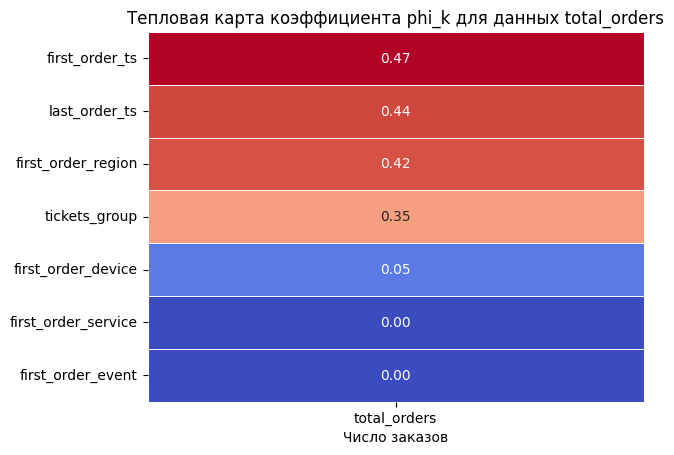

,total_orders
first_order_ts,0.47
last_order_ts,0.44
first_order_region,0.42
tickets_group,0.35
first_order_device,0.05
first_order_service,0.00
first_order_event,0.00


In [ ]:
profile_df['first_order_ts'] = profile_df['first_order_dt'].map(lambda x: x.timestamp())
profile_df['last_order_ts'] = profile_df['last_order_dt'].map(lambda x: x.timestamp())

correlation_matrix = profile_df[['first_order_ts', 'last_order_ts', 'first_order_device', 'first_order_region', 'first_order_service', 'first_order_event', 'total_orders', 'tickets_group']].phik_matrix(interval_cols=['first_order_ts', 'last_order_ts'])
sorted_correlations = correlation_matrix[correlation_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)

# Сохраняем матрицу корреляции признака total_orders с другими признаками
sns.heatmap(sorted_correlations,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.5,
            cbar=False
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k для данных total_orders')
plt.xlabel('Число заказов')

# Выводим график
plt.show()

sorted_correlations.style.format({'total_orders': '{:.2f}'}).background_gradient()

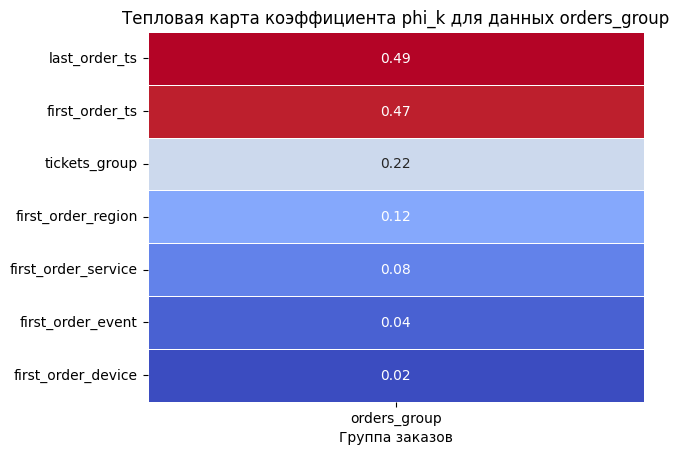

,orders_group
last_order_ts,0.49
first_order_ts,0.47
tickets_group,0.22
first_order_region,0.12
first_order_service,0.08
first_order_event,0.04
first_order_device,0.02


In [127]:
bins = [1, 2, 5, float('inf')]
labels = ['1 заказ', '2-4 заказа', '5+ заказов']

profile_df['orders_group'] = pd.cut(
    profile_df['total_orders'], 
    bins=bins, 
    labels=labels, 
    right=False
)

correlation_matrix = profile_df[['first_order_ts', 'last_order_ts', 'first_order_device', 'first_order_region', 'first_order_service', 'first_order_event', 'orders_group', 'tickets_group']].phik_matrix(interval_cols=['first_order_ts', 'last_order_ts'])
sorted_correlations = correlation_matrix[correlation_matrix.index != 'orders_group'][['orders_group']].sort_values(by='orders_group', ascending=False)

# Сохраняем матрицу корреляции признака orders_group с другими признаками
sns.heatmap(sorted_correlations,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            linewidths=0.5,
            cbar=False
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k для данных orders_group')
plt.xlabel('Группа заказов')

# Выводим график
plt.show()

sorted_correlations.style.format({'orders_group': '{:.2f}'}).background_gradient()

- Какие признаки наиболее связаны с количеством заказов?
    `last_order_ts` (49%) и `first_order_ts` (47%) больше всего связаны с количеством заказов. Это значит, что дата напрямую влияет на число купленных товаров. После идёт кол-во билетов 22% и регион с 12%. Остальные значения от 2% до 12% имеют несильное влияние на заказы пользователя.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**